In [21]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [22]:
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.signal as signal
from scipy.ndimage import shift
from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter, pulseShape
from optic.utils import parameters

In [23]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import optic.models.laser as laser

In [24]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [25]:
figsize(9,6)
plt.style.use('bmh')

## Laser rate equations

The modulation dynamics of the laser are modeled by coupled rate equations which describe the relation between the $N(t)$ carrier density, $S(t)$ photon density, and optical phase $\phi(t)$[1,2]:

\begin{align}
\frac{\mathrm{d}N(t)}{\mathrm{d}t} &= \frac{I(t)}{q V} - \frac{N(t)}{\tau_n} - a_0 v_g \left[ \frac{N(t) - N_t}{1+\epsilon S(t)} \right] S(t) + F_N(t) \\
\frac{\mathrm{d}S(t)}{\mathrm{d}t} &= \left\{ \Gamma a_0 v_g \left[ \frac{ N(t) - N_t}{1 + \epsilon \cdot S(t)} \right] -\frac{1}{\tau_{p}} \right\} S(t)+ \frac{\Gamma \beta N(t)}{\tau_{n}} +  F_S(t)\\
\frac{\mathrm{d}\phi(t)}{\mathrm{d}t} &= \frac{\alpha}{2} \left\{\Gamma a_0 v_g \left[N(t) - N_t\right]-\frac{1}{\tau_p} \right\} + F_{\phi}(t) 
\end{align}

where

|Symbol    |Description|
|:-:|:-|
|$I(t)$    | injected current|
|$q$       | electron charge|
|$V$       | active layer volume|
|$\tau_n$  | electron lifetime|
|$a_0$     | active layer gain coefficient|
|$v_g$     | group velocity |
|$N_t$| carrier density at transparency|
|$\epsilon$| gain compression factor|
|$F_i(t)$  | noise sources |
|$\Gamma$  | mode confinement factor|
|$\tau_p$  | photon lifetime|
|$\beta$   | fraction of spontaneous emission coupling|
|$\alpha$  | linewidth enchancement factor|

The time variations for the optical power $P(t)$ and laser chirp $C(t)$ are given by [1]
\begin{align}
P(t) &= \frac{S(t)}{2} \frac{V  \eta_0  h  v}{\Gamma \tau_p} \\
C(t) &= \frac{1}{2\pi}\frac{\mathrm{d}\phi(t)}{\mathrm{d}t}
\end{align}
where $hv$ is the photon energy at the frequency $v$ and $\eta_0$ is the total differential quantum efficiency.

### Laser noise

The random noise functions in (1)–(3) of the rate equations are assumed to be Gaussian random variables representing the Langevin noise sources related to carriers, photons, and phase, respectively [2]. The Langevin forces satisfy the general relations
\begin{align}
\langle F_i(t) \rangle &= 0, \\
\langle F_i(t) F_j(t') \rangle &= 2 D_{ij} \delta\left(t - t' \right),
\end{align}
where $\delta$ is Dirac’s delta function and $D_{ij}$ is the diffusion coefficient [2]
\begin{align}
D_{NN} &= V \frac{N_{sd}}{\tau_n} \left( \beta V S_{sd} + 1 \right), \\
D_{SS} &= \beta V N_{sd} \frac{\left(V S_{sd}+1\right)^3}{\tau_n},  \\
D_{\phi \phi} &= \Gamma v_g \sigma_g \frac{\left[N(t) - N_t \right]}{2S(t)}.
\end{align}
$\sigma_g$ the gain cross section, $N_{sd}$ and $S_{sd}$ represents the steady-state average values of the carrier and photon population:
\begin{align}
N_{sd} &= \frac{1}{\Gamma a_0 v_g \tau_p} + N_t, \\
S_{sd} &=  N_{sd} \frac{\tau_p}{\tau_n} \left(\frac{I}{I_{b}}-1\right)
\end{align}
where $I_b$ is the bias current. The Langevin force is white Gaussian with a mean of zero and standard deviation of $\sqrt{2D_{ij}}$ given as follows:
\begin{equation}
F_i(t) = N(0,1)\sqrt{2D_{ii}}
\end{equation}
where $N(0,1)$ denotes the Gaussian distributed random process with mean zero and standard deviation of 1.

### Numeric resolution

To solve the rate equations we must use Ruger-Kutta algorithms for differential coupled equations. The initial values of each variable are:
\begin{align}
S_0 &= \frac{\Gamma \tau_p}{q V}\left( I - I_{th} \right)\\
N_0 &= N_t + \frac{\left( 1 + \epsilon S_0 \right)}{\Gamma a_0 v_g \tau_p} \\
C_0 &= \frac{1}{2\pi} \frac{\alpha}{2} \left[ \Gamma v_g a_0 \left( N_0 - N_t \right) - \frac{1}{\tau_p} \right]
\end{align}

### References

1. J. C. Cartledge and R. C. Srinivasan, "Extraction of DFB laser rate equation parameters for system simulation purposes," in Journal of Lightwave Technology, vol. 15, no. 5, pp. 852-860, 1997.
1. I. Fatadin, D. Ives and M. Wicks, "Numerical simulation of intensity and phase noise from extracted parameters for CW DFB lasers," in IEEE Journal of Quantum Electronics, vol. 42, no. 9, pp. 934-941, 2006.
1. J. C. Cartledge and G.S. Burley, "The Effect of Laser Chirping on Lightwave System Performance," in Journal of Lightwave Technology, vol. 7, no. 3, pp. 568-573, 1989.
1. B. L. Espeyear, "MATLAB simulation of a distributed feedback (DFB) laser with chirp effects", Thesis, Naval Postgraduate School, Monterey:California, https://calhoun.nps.edu/handle/10945/30535.
1. Y. F. WEN, "EXTRACTION OF SEMICONDUCTOR LASER RATE EQUATION PARAMETERS FOR SIMULATION OF FIBER-OPTICAL COMMUNICATION SYSTEM PURPOSE", McMaster University, Hamilton, Ontario, Canada, https://macsphere.mcmaster.ca/bitstream/11375/12540/1/fulltext.pdf.

### Simulation based on Ref. [4].

In [26]:
laser_dfb_parameters = parameters()
# Espeyear thesis.
laser_dfb_parameters.noise_terms = False
laser_dfb_parameters.v       = 1.5e-10   # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 1.0e-9    # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.5e-16   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 8.5e+9    # [cm/s] group velocity
laser_dfb_parameters.n_t     = 1e18      # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 1e-17     # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 3e-12     # [s] photon lifetime
laser_dfb_parameters.gamma   = 0.4       # mode confinement factor
laser_dfb_parameters.beta    = 3e-5      # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 5         # linewidth enchancement factor
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.03886   # [A] i_bias
laser_dfb_parameters.i_max   = 0.02312   # [A] i_max
laser_dfb_parameters.eta_0   = 0.4       # total differential quantum efficiency
laser_dfb_parameters.lmbd    = 1300e-9   # [m] wavelength

In [27]:
# simulation parameters
SpS = 128
Rs = 0.5e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

In [28]:
# generate pseudo-random bit sequence
bitsTx = [0,1,0,0]

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [29]:
R = 316.32
C = 1e-12
f_cut = 1./(2.*np.pi*R*C)

def rc_filter(R, C, Fs, filter_type):
    if (1/(2*np.pi*R*C) > Fs/2):
        ('This analog filter cannot be realized with this sample rate')    
    # Default to allpass if invalid type is selected
    b = [1, 0]
    a = [1, 0]
    # Constants
    RC = R * C
    T  = 1 / Fs
    # Analog Cutoff Fc
    w = 1 / (RC)
    # Prewarped coefficient for Bilinear transform
    A = 1 / (np.tan((w*T) / 2))
    if(filter_type=='high'):
        b[0] = (A)     / (1 + A)
        b[1] = -b[0]
        a[1] = (1 - A) / (1 + A)
    if(filter_type=='low'):
        b[0] = (1)     / (1 + A)
        b[1] = b[0]
        a[1] = (1 - A) / (1 + A)
    return a,b

a,b=rc_filter(R, C, Fs, 'low')
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, sigTx, zi=zi*sigTx[0])

In [30]:
current = parameters()
current.t = t
current.signal = z

c:\Users\Adolfo\mambaforge\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Adolfo\mambaforge\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


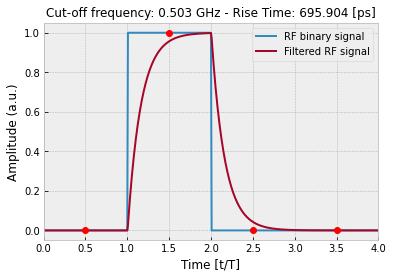

In [31]:
# Plot bits, rf signal and filtered signal
plt.figure(figsize=(6,4))
plt.plot(current.t*Rs, sigTx, label = 'RF binary signal', linewidth=2)
plt.plot(current.t*Rs, current.signal, label = 'Filtered RF signal', linewidth=2)
plt.plot(t[int(SpS/2)::SpS]*Rs, bitsTx, 'ro')
plt.title('Cut-off frequency: %.3f GHz - Rise Time: %.3f [ps]'%(1e-9*f_cut,2.2*R*C*1e12), fontsize=12)
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time [t/T]')
plt.xlim([0,4])
plt.legend(loc='upper right')
plt.grid(True)

In [32]:
# Solve rate equations
laser_dfb_parameters,current,sol = laser.laser_dfb(laser_dfb_parameters,current)
out = laser.laser_dynamic_response(sol['y'], laser_dfb_parameters)

Max. chirp freq. excursion: 6.187 GHz
Min. chirp freq. excursion: -0.981 GHz
I_threshold: 33.457 mA
I_on: 61.938 mA
I_off: 38.860 mA


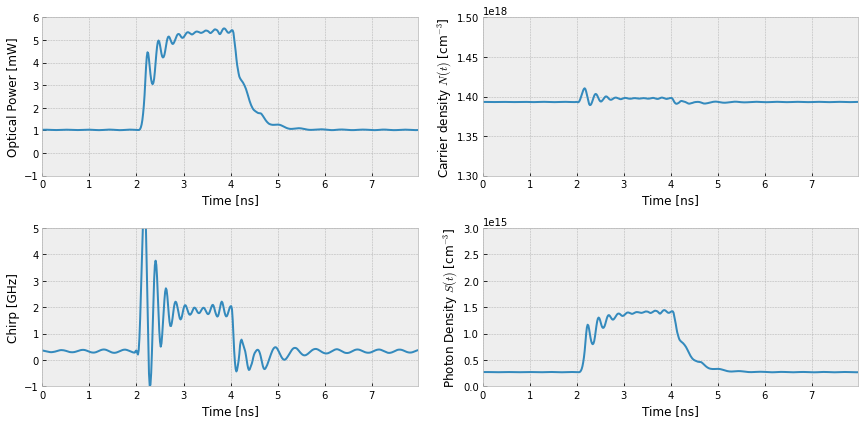

In [33]:
ax = laser.plot(current.t,out)
ax[0,0].set_ylim([-1,6])
ax[1,0].set_ylim([-1,5])
ax[0,1].set_ylim([1.3e18,1.5e18])
ax[1,1].set_ylim([0,3e15])
# See pag. 58 from Espeyear reference.
print('Max. chirp freq. excursion: %.3f GHz' %(1e-9*out.chirp.max()))
print('Min. chirp freq. excursion: %.3f GHz' %(1e-9*out.chirp.min()))
print('I_threshold: %.3f mA'%(1e3*laser_dfb_parameters.ith))
print('I_on: %.3f mA'%(1e3*np.real(current.signal.max())))
print('I_off: %.3f mA'%(1e3*np.real(current.signal.min())))

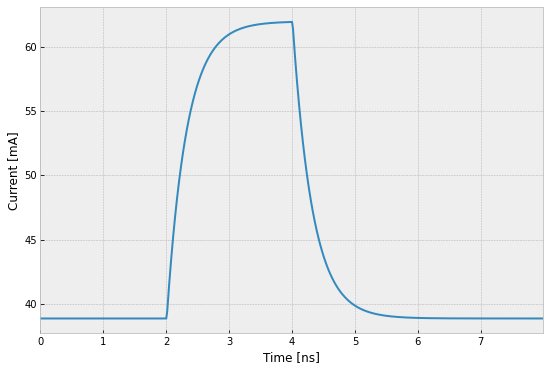

In [34]:
plt.plot(1e9*current.t, 1e3*current.signal)
plt.xlabel('Time [ns]')
plt.ylabel('Current [mA]')
plt.xlim([1e9*t.min(), 1e9*t.max()])
plt.grid(True)

In [35]:
bitsTx = np.random.randint(2, size=32)
n = np.arange(0, bitsTx.size)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

a,b=rc_filter(R, C, Fs, 'low')
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, sigTx, zi=zi*sigTx[0])

current = parameters()
current.t = t
current.signal = z

In [36]:
# Solve rate equations
laser_dfb_parameters,current,sol = laser.laser_dfb(laser_dfb_parameters,current)
out = laser.laser_dynamic_response(sol['y'], laser_dfb_parameters)

(0.0, 3000000000000000.0)

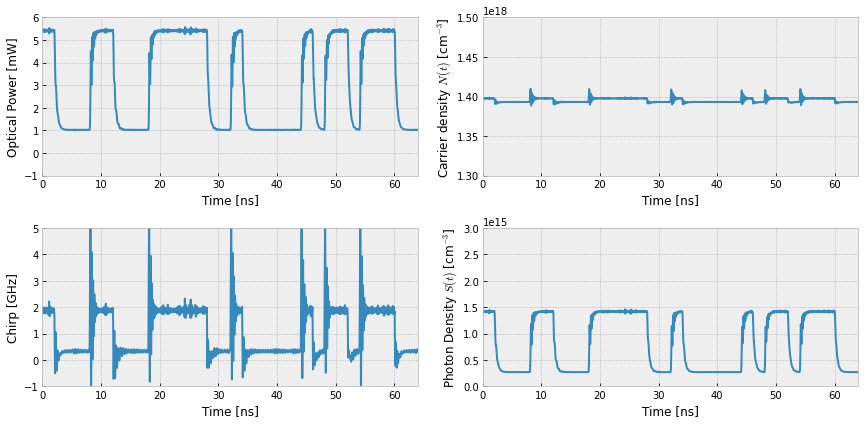

In [37]:
ax = laser.plot(current.t,out)
ax[0,0].set_ylim([-1,6])
ax[1,0].set_ylim([-1,5])
ax[0,1].set_ylim([1.3e18,1.5e18])
ax[1,1].set_ylim([0,3e15])

### LI plot

In [38]:
# generate pseudo-random bit sequence
bitsTx = [0, 0, 0, 0] 

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [39]:
from tqdm.notebook import tqdm

li_current = np.linspace(30e-3,100e-3,40)
laser_dfb_parameters.i_max   = 0
li_power = np.zeros(len(li_current))

for i in tqdm(range(len(li_current))):
    laser_dfb_parameters.i_bias  = li_current[i]
    laser_li,_,sol = laser.laser_dfb(laser_dfb_parameters,current)
    out = laser.laser_dynamic_response(sol['y'], laser_dfb_parameters)
    li_power[i] = out.power[-1]

  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\Adolfo\Documents\GitHub\OptiCommPy\optic\models\laser.py:62: RuntimeWarning: invalid value encountered in sqrt
  out.e_out = np.sqrt(np.real(out.power)) * np.exp(1j * out.phase)


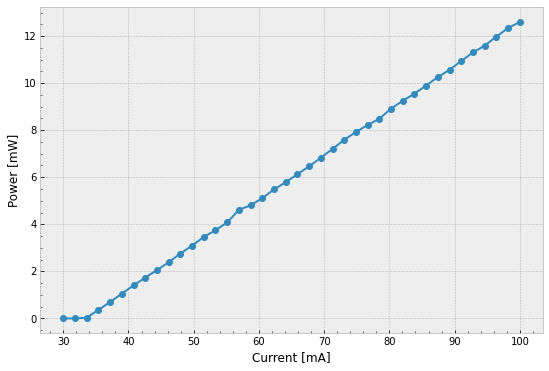

In [40]:
fig,ax = plt.subplots()
ax.plot(1e3*li_current,1e3*li_power, 'o-')
ax.set_xlabel('Current [mA]')
ax.set_ylabel('Power [mW]')
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
plt.show()